# Analysis of Antibiotics Prescription and Hospitalisation Risk

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
%matplotlib inline

In [2]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


In [4]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [5]:
input_20190101_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-01-01.csv.gz")
data201901 = pd.read_csv(input_20190101_file_path, compression='gzip')
data201901['date'] = '2019-01-01'

In [6]:
input_20190201_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-02-01.csv.gz")
data201902 = pd.read_csv(input_20190201_file_path, compression='gzip')
data201902['date'] = '2019-02-01'
data201902 = data201901.append(data201902, ignore_index=True)
#data201902.head(3)

In [7]:
input_20190301_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-03-01.csv.gz")
data201903 = pd.read_csv(input_20190301_file_path, compression='gzip')
data201903['date'] = '2019-03-01'
data201903 = data201902.append(data201903, ignore_index=True)
#data201903.head(3)

In [8]:
input_20190401_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-04-01.csv.gz")
data201904 = pd.read_csv(input_20190401_file_path, compression='gzip')
data201904['date'] = '2019-04-01'
data = data201903.append(data201904, ignore_index=True)
#data.head(3)

In [3]:
# data201901 = pd.read_csv(r'../output/measures/input_2019-01-01.csv.gz', compression='gzip')
# data201901['date'] = '2019-01-01'
# #data201901.head(3)

In [4]:
# data201902 = pd.read_csv(r'../output/measures/input_2019-02-01.csv.gz', compression='gzip')
# data201902['date'] = '2019-02-01'
# data201902 = data201901.append(data201902, ignore_index=True)
# #data201902.head(3)

In [5]:
# data201903 = pd.read_csv(r'../output/measures/input_2019-03-01.csv.gz', compression='gzip')
# data201903['date'] = '2019-03-01'
# data201903 = data201902.append(data201903, ignore_index=True)
# #data201903.head(3)

In [36]:
# data201904 = pd.read_csv(r'../output/measures/input_2019-04-01.csv.gz', compression='gzip')
# data201904['date'] = '2019-04-01'
# data = data201903.append(data201904, ignore_index=True)
# data.head(3)

In [9]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'covrx1_dat', 'covrx2_dat', 'admitted_date',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 76 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   bmi_date_measured                         3800 non-null   object 
 1   smoking_status_date                       400 non-null    object 
 2   most_recent_unclear_smoking_cat_date      400 non-null    object 
 3   flu_vaccine_med                           400 non-null    object 
 4   flu_vaccine_clinical                      400 non-null    object 
 5   antibacterial_prescriptions_date          17 non-null     object 
 6   sgss_positive                             400 non-null    object 
 7   covrx1_dat                                0 non-null      float64
 8   covrx2_dat                                0 non-null      float64
 9   admitted_date                             1200 non-null   object 
 10  died_date                           

In [11]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,antibacterial_prescriptions_date,sgss_positive,covrx1_dat,covrx2_dat,admitted_date,...,hiv_comor,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date
count,3800,400,400,400,400,17,400,0.0,0.0,1200,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000
unique,35,35,35,13,7,14,322,NaN,NaN,711,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,2021-09,2021-06,2021-01,2018-10,2018-08,2019-01-10,2021-08-22,NaN,NaN,2019-04-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01
freq,135,22,17,41,75,2,4,NaN,NaN,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,5020.018500,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300038,0.300038,0.300038,0.300038,0.300038,0.300038,0.300038,0.300038,2891.388279,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2553.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4991.500000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7539.500000,NaN


## Data Preparation

In [12]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'covrx1_dat', 'covrx2_dat', 'admitted_date',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [13]:
# define dictionaries

dict_sex = {'F': 'Female', 'M': 'Male'}
dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
dict_flu = {0: 'No', 1: 'Yes'}

In [14]:
# reoplace values of dictionaries with existing ones

data = data.replace({"sex": dict_sex})
data = data.replace({"ethnicity": dict_ethnicity})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"imd": dict_imd})
data = data.replace({"flu_vaccine": dict_flu})

In [15]:
#prep before plot

data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] == 0] = np.nan

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# Negative GP consultations mean what? Shall I remove them?

## Plots continuous factors

In [16]:
# function to generate histogram plots
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

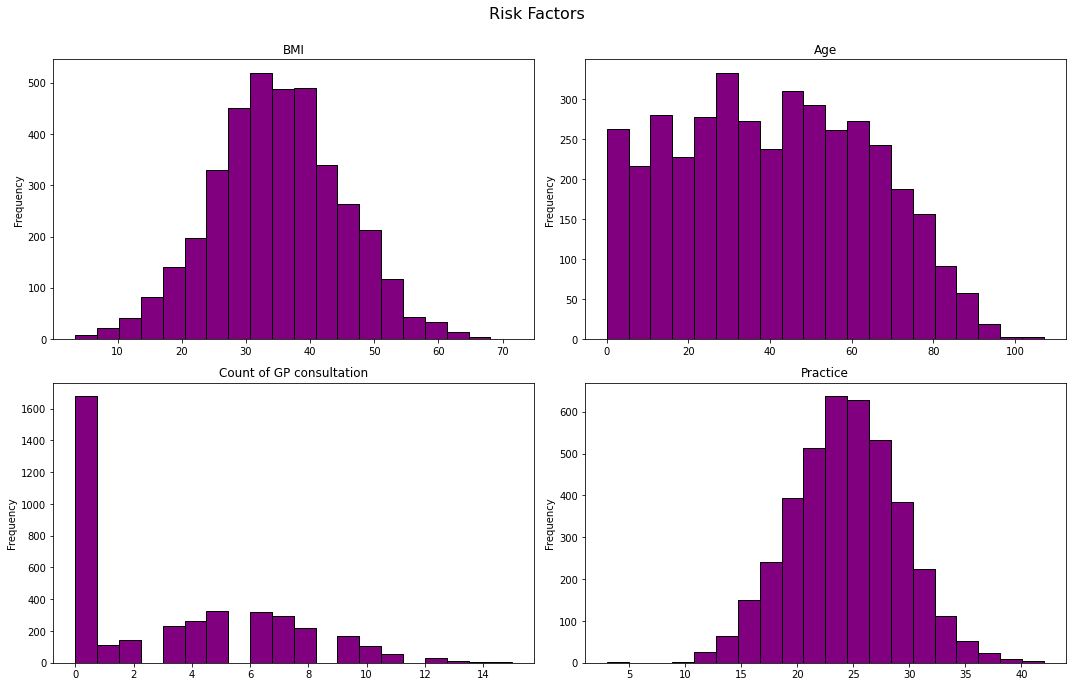

In [17]:
fig, axes = plt.subplots(2,2, 
                        figsize=(15, 10)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
#fig.delaxes(ax=axes[1,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

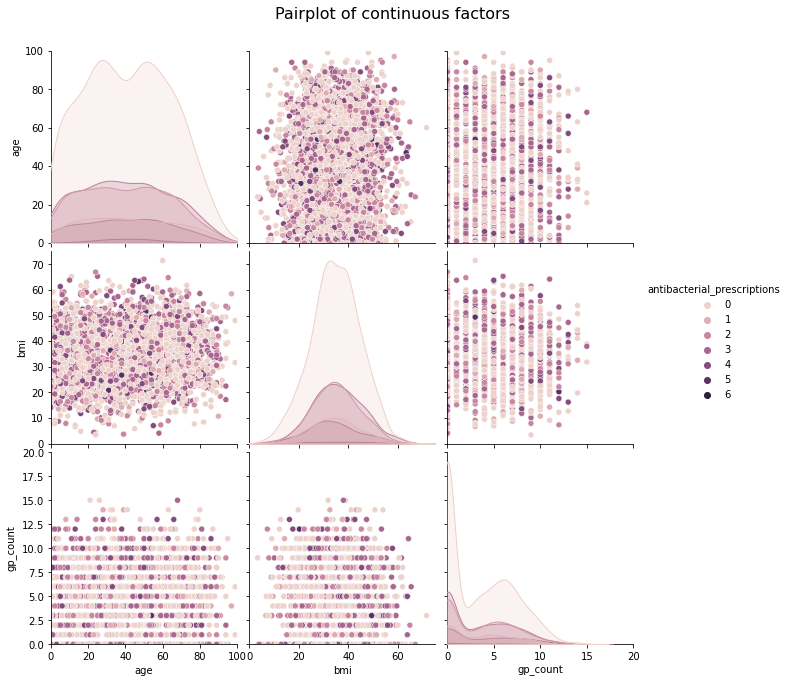

In [18]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count'#, 'practice'
                             ], 
                hue = 'antibacterial_prescriptions', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
#                'scatter_kws': {'alpha': 0.2}}, 
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

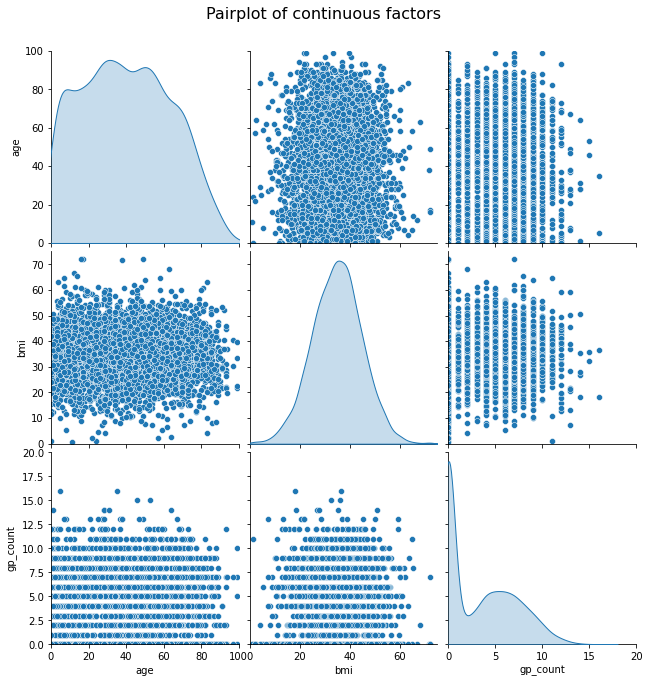

In [48]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count'#, 'practice'
                             ], 
                #hue = 'admitted', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
#                'scatter_kws': {'alpha': 0.2}}, 
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot2.jpg')
plt.show()

## Plot categorical factors

In [19]:
def create_lineplot(var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=25)

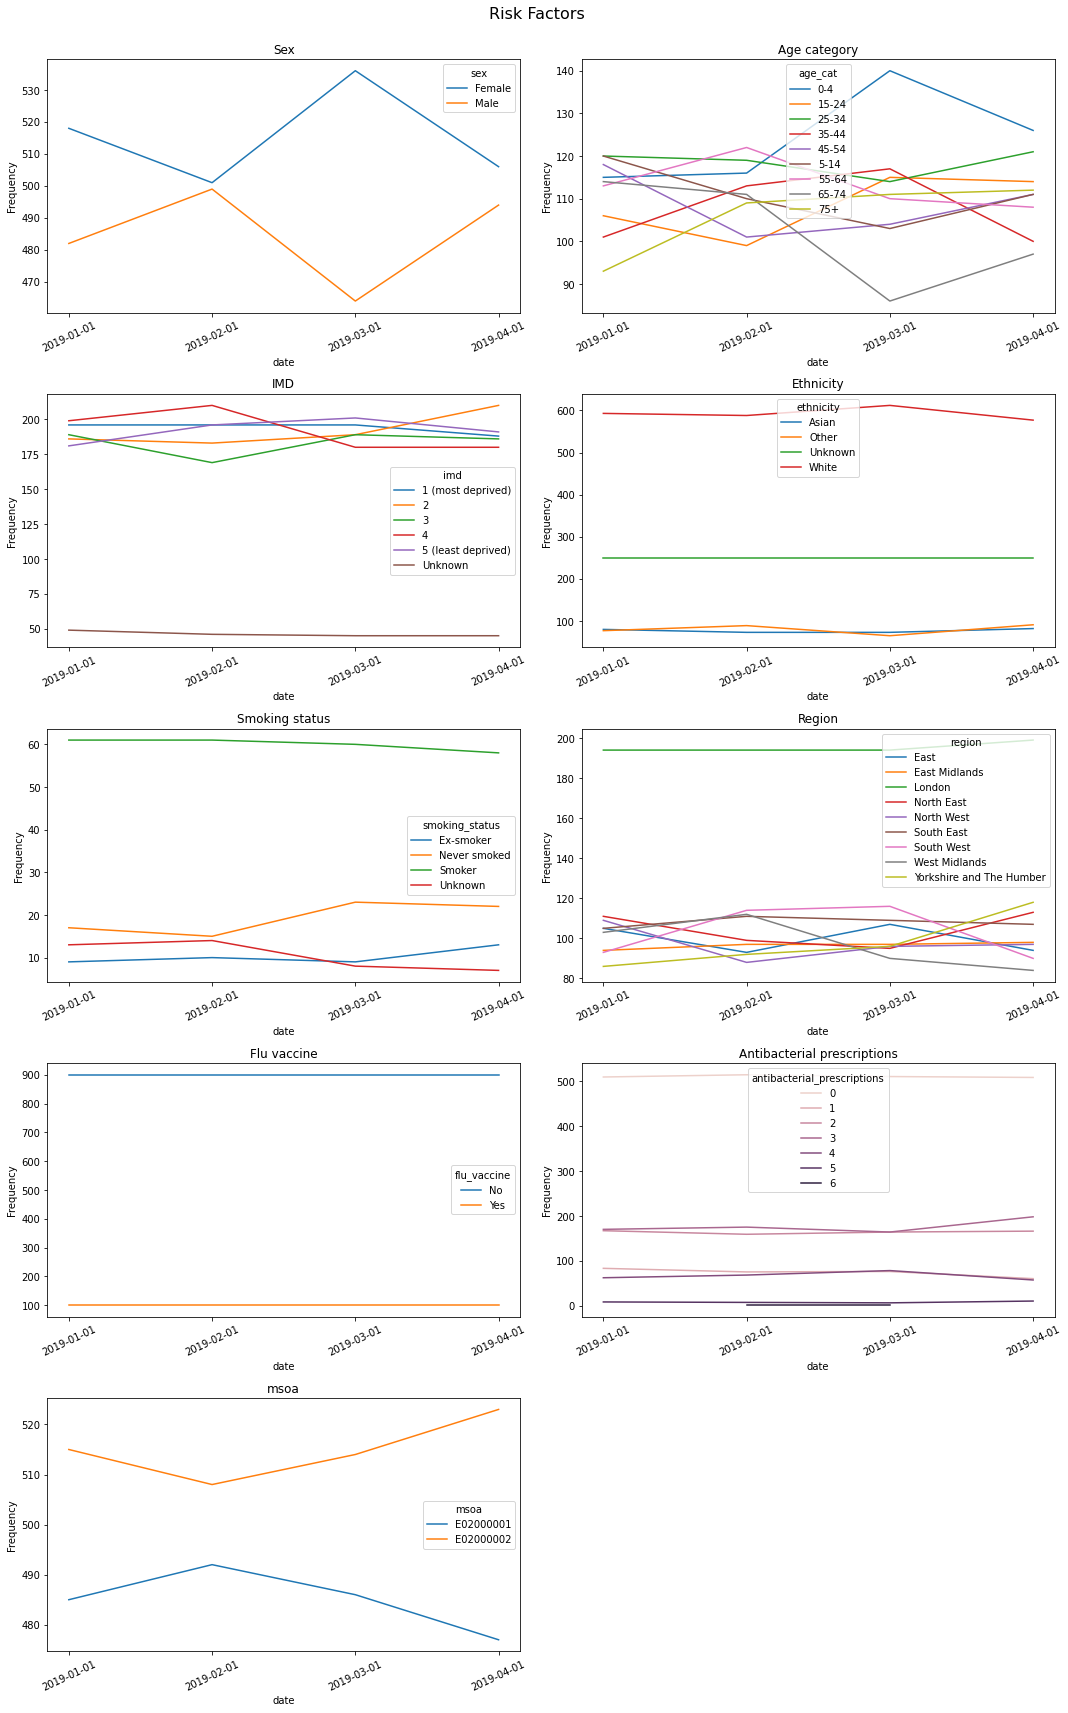

In [20]:
fig, axes = plt.subplots(5,2,
                        figsize=(15, 25)
                        )
create_lineplot('sex', 'Sex', axes[0,0])
create_lineplot('age_cat', 'Age category', axes[0,1])
create_lineplot('imd', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', axes[2,0])
create_lineplot('region', 'Region', axes[2,1])
create_lineplot('flu_vaccine', 'Flu vaccine', axes[3,0])
create_lineplot('antibacterial_prescriptions', 'Antibacterial prescriptions', axes[3,1])
create_lineplot('msoa', 'msoa', axes[4,0])
fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

### Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [21]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [22]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

In [23]:
data.CCI.value_counts()

3.0     553
2.0     535
4.0     470
1.0     445
0.0     383
5.0     335
6.0     330
7.0     234
8.0     193
9.0     145
10.0    121
11.0     90
12.0     56
13.0     40
14.0     24
15.0     19
16.0     13
18.0      6
17.0      5
19.0      2
20.0      1
Name: CCI, dtype: int64

## Hospital admissions related to infections 

In [ ]:
# exclusions


In [28]:
data.primary_care_covid.value_counts()

0    3600
1     400
Name: primary_care_covid, dtype: int64

In [29]:
data.sgss_positive.value_counts()

2021-08-22    4
2019-06-28    3
2019-11-20    3
2019-05-04    3
2020-06-22    3
             ..
2021-08-25    1
2019-04-01    1
2020-12-09    1
2019-07-09    1
2019-07-21    1
Name: sgss_positive, Length: 322, dtype: int64

In [26]:
data.columns

Index(['bmi_date_measured', 'smoking_status_date',
       'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med',
       'flu_vaccine_clinical', 'antibacterial_prescriptions_date',
       'sgss_positive', 'covrx1_dat', 'covrx2_dat', 'admitted_date',
       'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4',
       'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'age',
       'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi',
       'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp',
       'flu_vaccine', 'antibacterial_prescriptions', 'antibacterial_brit',
       'broad_spectrum_antibiotics_prescriptions', 'primary_care_covid',
       'admitted', 'uti_counts', 'lrti_counts', 'urti_counts',
       'sinusitis_counts', 'ot_externa_counts', 'otmedia_counts', 'uti_pt',
       'lrti_pt', 'urti_pt', 'sinusitis_pt', 'ot_externa_pt', 'otmedia_pt',
       'uti_ab_count_1', 'uti_ab_count_2', 'uti_ab_count_3', 'uti_ab_count_4',
       'lrti_ab_c

In [25]:
data.admitted_date

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3995    2019-02-03
3996           NaN
3997           NaN
3998           NaN
3999    2019-02-16
Name: admitted_date, Length: 4000, dtype: object

In [ ]:
#data['CCII'] = np.nan
#col0 = data.columns.get_loc('CCII')

# chalrson_point_1 = [data.columns.get_loc('mi_comor'), 
#                     data.columns.get_loc('cardiovascular_comor'),
#                     data.columns.get_loc('peripheral_vascular_comor'),
#                     data.columns.get_loc('chronic_obstructive_pulmonary_comor'),
#                     data.columns.get_loc('diabetes_comor'),
#                     data.columns.get_loc('dementia_comor'),
#                     data.columns.get_loc('peptic_ulcer_comor'),
#                     data.columns.get_loc('connective_tissue_comor'),
#                     data.columns.get_loc('mild_liver_comor')]

# chalrson_point_2 = [data.columns.get_loc('hemiplegia_comor'),
#                     data.columns.get_loc('mod_severe_renal_comor'),
#                     data.columns.get_loc('diabetes_complications_comor'),
#                     data.columns.get_loc('cancer_comor')]

# chalrson_point_3 = [data.columns.get_loc('mod_severe_liver_comor')]

# chalrson_point_4 = [data.columns.get_loc('metastatic_cancer_comor'),
#                     data.columns.get_loc('hiv_comor')]

In [ ]:
# for idx, x in enumerate(data['CCI']):
#     n=0
#     for y in chalrson_point_1:
#         if data.iat[idx, y] == 1:
#             n=n+1
#         data.iat[idx, col0]=n
#     for y in chalrson_point_2:
#         if data.iat[idx, y] == 1:
#             n=n+2
#         data.iat[idx, col0]=n
#     for y in chalrson_point_3:
#         if data.iat[idx, y] == 1:
#             n=n+3
#         data.iat[idx, col0]=n
#     for y in chalrson_point_4:
#         if data.iat[idx, y] == 1:
#             n=n+6
#         data.iat[idx, col0]=n

In [ ]:
#data.CCI.value_counts()

In [61]:
#ax = data['practice'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Practice')
#plt.ylabel('Percentage')
#plt.title('Percentage of practices')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
##plt.xlim(0, 100)
##plt.ylim(0, 1)
#plt.grid()
#plt.savefig(r'../output/hospitalisation_risk/practices.png', edgecolor='none')
#plt.show()

In [62]:
#sns.distplot(data['age'], hist=True, kde=True, 
#             bins=15, color = 'blue', 
#             #hist_kws={'edgecolor':'black'},
#             kde_kws={'linewidth': 2})

#plt.xlabel('Age')
##plt.ylabel('Frequency')
#plt.title('Histogram of age')
#plt.xlim(-10, 100)
##plt.ylim(0, 1100)
#plt.grid(True)
##plt.savefig(r'../output/hospitalisation_risk/antibacterial_prescirption.png', edgecolor='none')
#plt.show()

In [63]:
##data['age_cat'].value_counts().sort_index()

#data['age_cat'].value_counts(np.nan).sort_index().plot(kind='bar', figsize=(10, 5), rot=0, color = 'blue', alpha=0.5)
#plt.xlabel('Age category')
#plt.ylabel('Percentage')
#plt.title('Percentage of age categories')
##plt.xlim(0, 100)
#plt.ylim(0, 0.15)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.grid()
#print(data['age_cat'].value_counts().sort_index())
#plt.savefig(r'../output/hospitalisation_risk/age_categories.png', edgecolor='none')
#plt.show()

In [64]:
#for i, binwidth in enumerate([1, 5, 10, 15]):
    
#    # Set up the plot
#    ax = plt.subplot(2, 2, i + 1)
#    
#    # Draw the plot
#    ax.hist(data['bmi'], bins = int(180/binwidth), 
#             color = 'blue', edgecolor = 'black')
    
#    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 10)
#    ax.set_xlabel('Delay (min)', size = 12)
#    ax.set_ylabel('Flights', size= 12)

#plt.tight_layout()
#plt.show()

In [65]:
#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [66]:
#fig, axs = plt.subplots(2, 2, 
#                        #figsize=(18, 14)
#                        )

#axs[0, 0].hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#axs[0, 1].hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#axs[1, 0].hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#axs[1, 1].hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#plt.tight_layout()
#plt.show()

In [67]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
#fig.suptitle('Vertically stacked subplots')

#ax1.hist(data['bmi'], bins = int(180/1), color = 'blue', edgecolor = 'black')
#ax2.hist(data['bmi'], bins = int(180/5), color = 'blue', edgecolor = 'black')
#ax3.hist(data['bmi'], bins = int(180/10), color = 'blue', edgecolor = 'black')
#ax4.hist(data['bmi'], bins = int(180/15), color = 'blue', edgecolor = 'black')

#for ax in fig.get_axes():
#    ax.label_outer()
#    ax.set(xlabel='x-label', ylabel='y-label')

#plt.tight_layout()
#plt.show()